### Chile Inflation Nowcast
* This code is a first attempt as using the Cleveland Fed Nowcast Methodology to predict headline inflation
* https://www.clevelandfed.org/indicators-and-data/inflation-nowcasting
* Hope to expand it to include additional explanatory variables soon

In [15]:
#Import statements
import pandas as pd 
import numpy as np
import yfinance as yf
from matplotlib import pyplot as plt
from fredapi import Fred
from datetime import datetime
import statsmodels.api as sm
import config
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
fred = Fred(api_key=config.api_key)

In [16]:
#Get Exchange rate data and Energy price data from Yahoo Finance

# Define the ticker list
tickers_list = ['CLP=X','CL=F','BCH','MELI','FALABELLA.SN','COPEC.SN','CCU']

# Fetch the data
data = yf.download(tickers_list,'1990-1-1')['Adj Close']

#Organize the data for merging and convert to monthly % changes
dfyf = data.groupby(pd.PeriodIndex(data.index, freq="M"))[tickers_list].mean()
dfyf.reset_index(inplace=True)
dfyf['Date'] = dfyf['Date'].dt.strftime('%Y/%m/%d')
dfyf['Date'] = pd.to_datetime(dfyf['Date'])
dfyf['month'] = dfyf['Date'].dt.month
dfyf['year'] = dfyf['Date'].dt.year

#Merging dates start first day of month, so use that detail
dfyf['Date'] = dfyf['Date'].apply(lambda x: datetime(x.year, x.month, 1))
dfyf = dfyf.set_index('Date')

dfyf[tickers_list] = 100*dfyf[tickers_list].pct_change(3)

dfyf.head()

[*********************100%***********************]  7 of 7 completed


,CLP=X,CL=F,BCH,MELI,FALABELLA.SN,COPEC.SN,CCU,month,year
Date,,,,,,,,,
1992-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1992
1992-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1992
1992-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,1992
1992-12-01,NaN,NaN,NaN,NaN,NaN,NaN,11.521192,12,1992
1993-01-01,NaN,NaN,NaN,NaN,NaN,NaN,36.041044,1,1993


In [17]:
#Define function for collecting data from FRED
def fredget(varlist, start_date, end_date, plots=True,freq="",name_map = dict()):
    df_collect = pd.DataFrame()

    for var in varlist:
        df_add = fred.get_series(var, observation_start = start_date, observation_end=end_date, frequency =freq).to_frame(name = var)
        info_add = fred.get_series_info(var).to_frame(name = var)
        print(var)
        #If user changes the 
        if freq != "":
            info_add.loc['cur_freq', var] = freq
            
        if var in name_map:
            info_add.loc['user_title', var] = name_map[var]
        else:
            info_add.loc['user_title', var] = info_add.loc['title', var]
                    
        if plots == True:
            df_add.plot(y=var, use_index=True, kind='line', title = info_add.loc['user_title', var], ylabel = info_add.loc['units', var] )
            
        if df_collect.empty == True:
            df_collect = df_add
            info_store = info_add
        else:
            df_collect = pd.merge(df_collect, df_add, left_index=True, right_index=True, how='outer')
            info_store = pd.merge(info_store, info_add, left_index=True, right_index=True, how='left')
            
    df_collect.sort_index()
    return df_collect, info_store


In [18]:
#Define FRED codes to search for 
FRED_list = ['CPALTT01CLM657N','CPGREN01CLM657N','CPGRLE01CLM657N','WPUID61','PCOPPUSDM','BAA10Y','VIXCLS','CUSR0000SAD']

s_d ='1990-01-01'
e_d='2023-03-01'

#Collect variables into a monthly df
df_collect_m, dfinfo_m = fredget(FRED_list, s_d, e_d, freq = "m", plots=False)

#Convert this series to MoM % changes
df_collect_m['WPUID61'] = df_collect_m['WPUID61'].pct_change(3)*100
df_collect_m['PCOPPUSDM'] = df_collect_m['PCOPPUSDM'].pct_change(3)*100

CPALTT01CLM657N
CPGREN01CLM657N
CPGRLE01CLM657N
WPUID61
PCOPPUSDM
BAA10Y
VIXCLS
CUSR0000SAD


In [19]:
#Collect both the FRED and Yahoo Finance Data into one DF
df = dfyf.merge(df_collect_m, how='inner',left_index=True,right_index=True)

#Rename columns with non-descriptive names
rename_cols = {"CPALTT01CLM657N":"headline","CPGREN01CLM657N":"energy","CPGRLE01CLM657N":"core","WPUID61":"USppi","PCOPPUSDM":"copper","CLP=X":"exrate","CL=F":"oil","CUSR0000SAD":"goods"}
df = df.rename(columns=rename_cols)
#generate Month dummy variables for seasonal effects
dummies = pd.get_dummies(df['month']).rename(columns=lambda x: 'M_' + str(x))
df = pd.concat([df, dummies], axis=1)

"""This concludes the data collection"""

'This concludes the data collection'

#### Plot the input series to get a sense of the info they contain

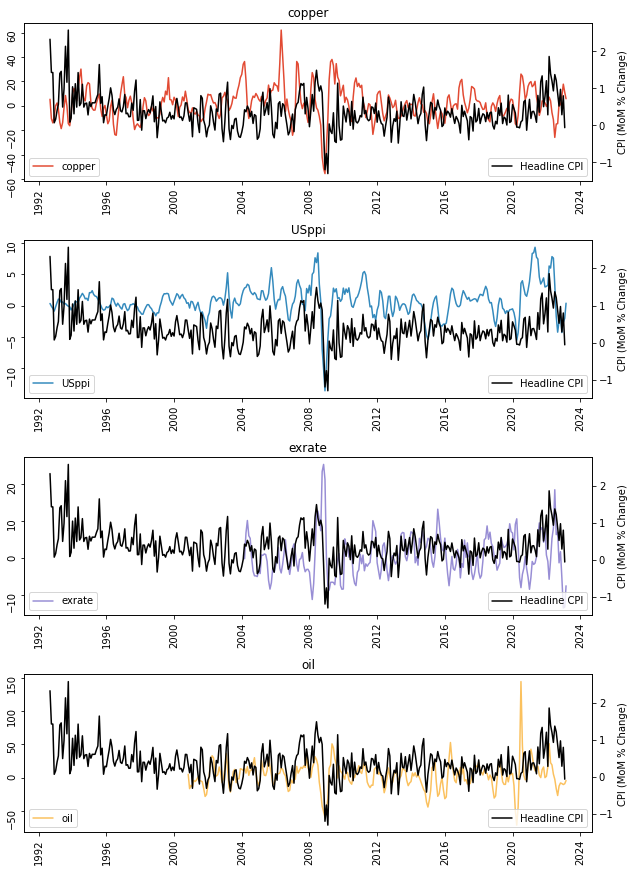

In [20]:

plotlist = ['copper','USppi','exrate','oil']

#Plot Negative sentiment vs. Relevant covariates
fig, axs = plt.subplots(4,1, figsize = (9, 12))

colorlist = ['#E24A33','#348ABD','#988ED5','#FBC15E','#8EBA42','#FFB5B','#777777']

for i, var in enumerate(plotlist):
    
    fig.tight_layout()
           
    #Define plots here 
    axs[i].set_title(var)
    axs[i].tick_params(rotation=90)
    axs[i].plot(df[var],color = colorlist[i],label =var,solid_capstyle='round')
    axs[i].legend(loc='lower left')

    
    ax2 = axs[i].twinx()
    ax2.plot(df['headline'],'k',label ='Headline CPI',solid_capstyle='round')
    ax2.legend(loc='lower right')
    ax2.set_ylabel('CPI (MoM % Change)')
    
    



In [21]:
#Generate "forecasts" for certain variables as 12m avg of past values + also generate lags
df_setup = df
lag_list = ['core','headline','copper','oil','BCH']

for f in lag_list:
    reglist = list()
    for i in range(1,13):
        varname = f'{f}_L_{i}'
        reglist.append(varname)
        df_setup[varname] = df_setup[f].shift(i) 
    df_setup[f'{f}_fcast'] =  df_setup[reglist].mean(axis=1)
   

#Set the time period
df_setup = df_setup.loc['2005-01-01':'2023-01-01']

#Define train test split for model selection & Validation
split_date = '2021-6-1'
df_train = df_setup.loc[df_setup.index <= split_date].copy()
df_test = df_setup.loc[df_setup.index > split_date].copy()


In [22]:
#Set the target
y = df_train['headline']
y_test = df_test['headline']

#AR1 baseline prediction
x_AR = df_train['headline_L_1']
x_AR = sm.add_constant(x_AR)

x_AR_test = df_test['headline_L_1']
x_AR_test= sm.add_constant(x_AR_test)

modelAR = sm.OLS(y, x_AR).fit()
#Get fitted values
df_train['fittedAR'] = modelAR.fittedvalues
df_test['fittedAR'] = modelAR.predict(x_AR_test)

modelAR.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               headline   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     46.58
Date:                Thu, 04 May 2023   Prob (F-statistic):           1.07e-10
Time:                        01:06:22   Log-Likelihood:                -75.339
No. Observations:                 198   AIC:                             154.7
Df Residuals:                     196   BIC:                             161.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1550      0.031      5.062      0.000       0.095       0.215
headline_L_1     0.4355      0.064      6.825      0.000       0.310       0.561
==============================================================================
Omnibus:                        6.483   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                8.842
Skew:                          -0.184   Prob(JB):                       0.0120
Kurtosis:                       3.967   Cond. No.                         2.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
#Generate best regression predictions
x_set = ['oil','exrate','headline_L_1','USppi','M_3', 'M_9', 'M_11']

#Define x & y
x = df_train[x_set]
x = sm.add_constant(x)

x_test = df_test[x_set]
x_test = sm.add_constant(x_test)

#Fit to the training data 
OLSmodel = sm.OLS(y, x).fit()

#Get predicted values
df_train['fittedOLS'] = OLSmodel.fittedvalues
df_test['fittedOLS'] = OLSmodel.predict(x_test)

OLSmodel.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               headline   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     20.80
Date:                Thu, 04 May 2023   Prob (F-statistic):           1.20e-20
Time:                        01:06:23   Log-Likelihood:                -40.121
No. Observations:                 198   AIC:                             96.24
Df Residuals:                     190   BIC:                             122.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1185      0.029      4.079      0.000       0.061       0.176
oil              0.0022      0.001      1.582      0.115      -0.001       0.005
exrate           0.0197      0.005      3.978      0.000       0.010       0.029
headline_L_1     0.3014      0.064      4.715      0.000       0.175       0.427
USppi            0.0428      0.010      4.118      0.000       0.022       0.063
M_3              0.2194      0.079      2.788      0.006       0.064       0.375
M_9              0.3322      0.080      4.165      0.000       0.175       0.489
M_11            -0.2239      0.082     -2.746      0.007      -0.385      -0.063
==============================================================================
Omnibus:                        1.420   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.492   Jarque-Bera (JB):                1.064
Skew:                          -0.138   Prob(JB):                        0.587
Kurtosis:                       3.231   Cond. No.                         89.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/wcrossb/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/wcrossb/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

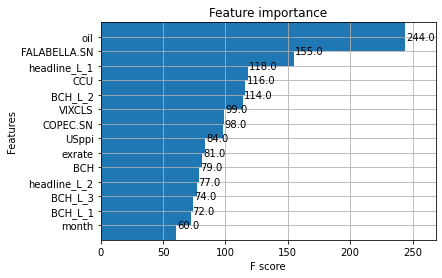

In [24]:
#Fit the XGB model here
x_set = ['oil','FALABELLA.SN','COPEC.SN','CCU','BCH','BCH_L_1','BCH_L_2','BCH_L_3','headline_L_1','headline_L_2','VIXCLS','exrate','USppi','month']

xgb_laglist = []
for var in xgb_laglist:
       add_list =df.filter(like=var).columns.to_list()
       x_set = x_set + add_list

#x_set.remove('headline')

#Define x & y
x = df_train[x_set]
x_test = df_test[x_set]

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(x, y, eval_set=[(x, y), (x_test, y_test)],eval_metric='rmse', early_stopping_rounds=200, verbose=False) # Change verbose to True if you want to see it train

df_test['fittedXGB'] = reg.predict(x_test)

plot_importance(reg, height=2,max_num_features=20)


AR(1) MSE: 0.3704 ----- MAE: 0.5059
OLS MSE: 0.2932 ----- MAE: 0.4397
XGBoost MSE: 0.3366 ----- MAE: 0.4687
3 Model Avg. Pred MSE: 0.3115 ----- MAE: 0.4569


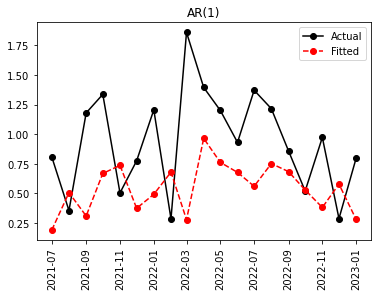

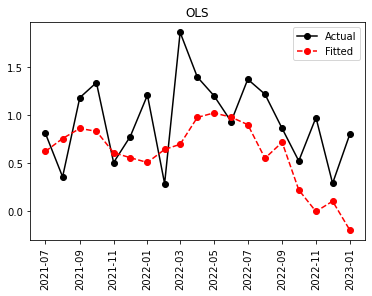

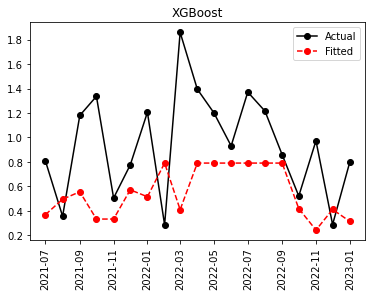

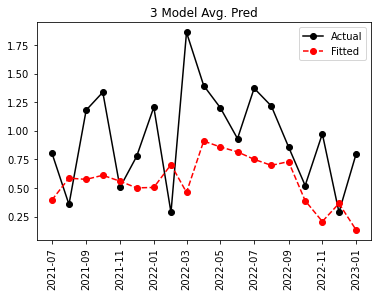

In [25]:
#Present a model summary Comparison
df_test['avgfit'] =  df_test[['fittedAR','fittedOLS','fittedXGB']].mean(axis=1)

model_specs = {'AR(1)':'fittedAR','OLS':'fittedOLS','XGBoost':'fittedXGB','3 Model Avg. Pred':'avgfit'}

for model in model_specs:
    varname = model_specs[model]
    plt.figure()
    plt.plot(df_test['headline'],'k',label ='Actual',marker='o')
    plt.plot(df_test[varname],color='r',linestyle='dashed', marker='o',
     markerfacecolor='red', label ='Fitted')
    plt.title(model)
    plt.legend()
    plt.xticks(rotation=90)
        
    MSE = mean_squared_error(df_test['headline'], df_test[varname]).round(4)
    MAE = mean_absolute_error(df_test['headline'], df_test[varname]).round(4)
    print(f'{model} MSE: {MSE} ----- MAE: {MAE}')


In [26]:
#Plot the months with the worst prediction misses
df_test['error'] = df_test['headline'] - df_test['avgfit']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_month = df_test.groupby(['year','month']).mean()[['headline','avgfit','error','abs_error']]
    
error_by_month.sort_values('abs_error', ascending=False).head(10)

headline    avgfit     error  abs_error
year month                                         
2022 3      1.860465  0.460975  1.399490   1.399490
     11     0.973236  0.206234  0.767002   0.767002
2021 10     1.336922  0.610508  0.726415   0.726415
2022 1      1.206399  0.504222  0.702177   0.702177
2023 1      0.798326  0.131619  0.666707   0.666707
2022 7      1.371653  0.750154  0.621499   0.621499
2021 9      1.180209  0.574836  0.605372   0.605372
2022 8      1.216173  0.697297  0.518876   0.518876
     4      1.395231  0.910054  0.485177   0.485177
     2      0.285048  0.703894 -0.418846   0.418846